In [1]:
import pandas as pd
import numpy as np
import talib as ta


In [2]:
df = pd.read_csv('BA.csv')

df['Date'] = pd.to_datetime(df['Date'])

df.index = df['Date']

df.head()
# df.describe()


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-02-03,2015-02-03,146.369995,148.000000,146.179993,147.339996,128.639938,5978200
2015-02-04,2015-02-04,145.970001,148.389999,145.929993,147.220001,128.535172,4766200
2015-02-05,2015-02-05,147.259995,148.869995,146.460007,148.600006,129.740036,4252600
2015-02-06,2015-02-06,148.619995,148.889999,147.699997,148.000000,129.216217,4398800
2015-02-09,2015-02-09,146.160004,148.160004,145.630005,147.580002,128.849487,4202900


In [3]:
df = df.drop(["Date"], axis=1)

In [4]:
#5.1. Step 1: extract technical indicators

#Define Technical Indicators
#_______________________________________________________________________

#Simple Moving Average  
sma = ta.SMA(df.Close,900)
df['MA25'] = sma
df = df.fillna(0)

# RSI
df["RSI"] = ta.RSI(df.Close,14)

# Stochastic K
df["Stoch_K"], df["Stoch_D"] = ta.STOCH(df["High"], df["Low"], df["Close"], fastk_period=14, slowk_period=3, slowk_matype=0, 
                                       slowd_period=3, slowd_matype=0)

# MACD
df['MACD'], df['MACDSignal'], df['MACDHist'] = ta.MACD(df.Close, fastperiod= 12, slowperiod= 26, signalperiod= 9)

# Williams R%
df["WILLR"] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14) 

df.tail()

,Open,High,Low,Close,Adj Close,Volume,MA25,RSI,Stoch_K,Stoch_D,MACD,MACDSignal,MACDHist,WILLR
Date,,,,,,,,,,,,,,
2020-01-27,316.209991,321.260010,314.579987,316.600006,316.600006,7468100,284.427944,39.800736,39.610963,32.293929,-6.286475,-5.699115,-0.587360,-66.530010
2020-01-28,318.049988,319.359985,314.000000,316.559998,316.559998,5502200,284.638578,39.775639,39.323804,37.478964,-6.322034,-5.823699,-0.498335,-64.521934
2020-01-29,324.350006,327.179993,319.140015,322.019989,322.019989,12454700,284.852078,44.883662,39.474169,39.469645,-5.842293,-5.827418,-0.014875,-50.525550
2020-01-30,320.500000,325.350006,317.640015,323.299988,323.299988,6022000,285.067200,46.039141,47.928693,42.242222,-5.297740,-5.721482,0.423742,-41.166436
2020-01-31,321.750000,321.929993,316.989990,318.269989,318.269989,4996800,285.279755,42.287379,51.987834,46.463565,-5.211977,-5.619581,0.407604,-52.344512


In [5]:
# 5.2. Step 2: trend analysis using technical indicators

#make MA25 into a series
MA25 = df.iloc[:,6]

# Up trend is 1, No trend is 0, and Down trend is -1
df['Trend'] = MA25.rolling('5d').apply(lambda x: np.sign(x[-1] - x[0]))

df.tail()
#If close > MA25 and MA25 is rising for last 5 days then 1 (Uptrend)
#If close < MA25 and MA25 is declining for last 5 days then -1 (Downtrend)
#If neither are true then 0 (Notrend)
def f(row):
    if row['Close'] > row['MA25'] and row['Trend'] == 1:
        val = 1
    elif row['Close'] < row['MA25'] and row['Trend'] == -1:
        val = -1
    else:
        val = 0
    return val
df['Trend'] = df.apply(f, axis=1)
# df.tail(n=1)

C:\Users\JMadd\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  import sys


In [6]:
#5.3. Step 3: trading signal generation from trend analysis

Close = df.iloc[:,3]
df["UpTrend"] = (Close - Close.rolling('3 D').min())/(Close.rolling('3 D').max() - Close.rolling('3 D').min())
# * .5 + .5
df["DownTrend"] = (Close - Close.rolling('3 D').min())/(Close.rolling('3 D').max() - Close.rolling('3 D').min())
# * .5

def g(row):
    if row['Trend'] == 1:
        val = row['UpTrend']
    elif row['Trend'] == -1:
        val = row['DownTrend']
    else:
        val = 0
    return val
df['Trade_Signal'] = df.apply(g, axis=1)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,MA25,RSI,Stoch_K,Stoch_D,MACD,MACDSignal,MACDHist,WILLR,Trend,UpTrend,DownTrend,Trade_Signal
Date,,,,,,,,,,,,,,,,,,
2020-01-27,316.209991,321.260010,314.579987,316.600006,316.600006,7468100,284.427944,39.800736,39.610963,32.293929,-6.286475,-5.699115,-0.587360,-66.530010,1,NaN,NaN,NaN
2020-01-28,318.049988,319.359985,314.000000,316.559998,316.559998,5502200,284.638578,39.775639,39.323804,37.478964,-6.322034,-5.823699,-0.498335,-64.521934,1,0.0,0.0,0.0
2020-01-29,324.350006,327.179993,319.140015,322.019989,322.019989,12454700,284.852078,44.883662,39.474169,39.469645,-5.842293,-5.827418,-0.014875,-50.525550,1,1.0,1.0,1.0
2020-01-30,320.500000,325.350006,317.640015,323.299988,323.299988,6022000,285.067200,46.039141,47.928693,42.242222,-5.297740,-5.721482,0.423742,-41.166436,1,1.0,1.0,1.0
2020-01-31,321.750000,321.929993,316.989990,318.269989,318.269989,4996800,285.279755,42.287379,51.987834,46.463565,-5.211977,-5.619581,0.407604,-52.344512,1,0.0,0.0,0.0


In [7]:
#I added .tail(n=Length - 32) to omit values where the indicators = 0 since the machine learning agorithm trains on the values 
#of the indicators and the MACD doesn't generate values until 33 periods have passed.
Length = ((df.shape[0])- 500)


df2 = (df[['MA25', 'RSI', 'Stoch_K', 'Stoch_D', 'MACD', 'WILLR', 'Trade_Signal']].copy().tail(n=Length).copy())


#I get some na values without this and I'm worried that using this and
# having those values as zero will mess with the algorithms interpretation of the data
df2 = df2.fillna(0)

# df2.describe()
df2.head()
print(Length)

758


In [8]:
#5.5. Step 5: network structure creation and training using ELM

target_column = ['Trade_Signal'] 
predictors = list(set(list(df2.columns))-set(target_column))
#line 3 here fufills the data normalization of Step 5.4
df2[predictors] = (df2[predictors] - df2[predictors].min())/(df2[predictors].max() - df2[predictors].min())

#df2.describe()
#df2.info()
df2.tail()
# df2.head()

,MA25,RSI,Stoch_K,Stoch_D,MACD,WILLR,Trade_Signal
Date,,,,,,,
2020-01-27,0.997014,0.219255,0.384290,0.283008,0.196046,0.334700,0.0
2020-01-28,0.997752,0.218887,0.381273,0.340680,0.194881,0.354781,0.0
2020-01-29,0.998501,0.293903,0.382853,0.362822,0.210588,0.494745,1.0
2020-01-30,0.999255,0.310873,0.471685,0.393661,0.228417,0.588336,1.0
2020-01-31,1.000000,0.255774,0.514335,0.440614,0.231224,0.476555,0.0


In [9]:
X = df2[predictors]

y = df2[target_column]

# y = y.T

print(X.shape); print(X.ndim); print(y.shape); print(y.ndim)
print(X)

(758, 6)
2
(758, 1)
2
               WILLR      MA25       RSI      MACD   Stoch_D   Stoch_K
Date                                                                  
2017-01-27  0.827457  0.000000  0.705210  0.497646  0.876747  0.897536
2017-01-30  0.667667  0.000000  0.594207  0.498893  0.890254  0.818854
2017-01-31  0.506377  0.000000  0.497010  0.493148  0.799343  0.669092
2017-02-01  0.547637  0.000000  0.513472  0.489044  0.684150  0.571089
2017-02-02  0.415849  0.000000  0.440246  0.480369  0.565600  0.482893
...              ...       ...       ...       ...       ...       ...
2020-01-27  0.334700  0.997014  0.219255  0.196046  0.283008  0.384290
2020-01-28  0.354781  0.997752  0.218887  0.194881  0.340680  0.381273
2020-01-29  0.494745  0.998501  0.293903  0.210588  0.362822  0.382853
2020-01-30  0.588336  0.999255  0.310873  0.228417  0.393661  0.471685
2020-01-31  0.476555  1.000000  0.255774  0.231224  0.440614  0.514335

[758 rows x 6 columns]


In [10]:
Xindex = np.array([[1], [2], [3], [4], [5], [6]])

Xindex = Xindex.T

print(Xindex.shape); print(Xindex)

(1, 6)
[[1 2 3 4 5 6]]


In [11]:
feb = np.outer(X, Xindex).flatten(order='F').reshape(-1, 6)

print(feb.shape); print(feb)

(4548, 6)
[[0.82745667 0.         0.70521007 0.49764617 0.87674727 0.89753609]
 [0.66766749 0.         0.59420652 0.49889269 0.89025383 0.81885446]
 [0.50637652 0.         0.49700951 0.49314834 0.79934295 0.6690915 ]
 ...
 [2.96846702 5.99100509 1.76341998 1.26352826 2.17693304 2.2971161 ]
 [3.53001381 5.99552953 1.86523657 1.37049918 2.36196604 2.83010932]
 [2.85932926 6.         1.53464491 1.38734638 2.64368511 3.08600715]]


In [14]:
# feb = np.sum(
# feb=cx.reshape(-1, 6)
# print(feb.shape); print(feb)

In [15]:
#  Functional Expansion Block

# feb = np.outer(X, Xindex).flatten(order='F')
# feb = np.sum(cx.reshape(-1, 6), axis=1)
# feb = np.tanh(feb)

#all on one line
feb = np.tanh(np.sum(np.outer(X, Xindex).flatten(order='F').reshape(-1, 6), axis=1))

print(feb.shape); print(feb.ndim);
print(feb)

(4548,)
1
[0.99900875 0.99806485 0.9946968  ... 1.         1.         1.        ]


In [16]:
expanded_inputs = feb.reshape(Length, -1)

# feb = feb.reshape(6, -1)
# print(feb)

In [17]:
cx = feb.reshape(1, len(feb) )

# cx= feb

print(cx.shape); print(cx.ndim); print(cx)

(1, 4548)
2
[[0.99900875 0.99806485 0.9946968  ... 1.         1.         1.        ]]


In [18]:
# initialize random weights
synaptic_weights = np.random.random((1, (Length * 6)))

print(synaptic_weights.shape); print(synaptic_weights.ndim);print(synaptic_weights)

(1, 4548)
2
[[0.92671469 0.37044332 0.85644721 ... 0.91616984 0.38687902 0.8308024 ]]


In [19]:
I = np.identity(len(feb))

print(I.shape); print(I.ndim); print(I)

(4548, 4548)
2
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [20]:
lamb = 1 

W = ((cx.T.dot(cx) + lamb * I)**-1) * (cx.T.dot(synaptic_weights))

# W = np.linalg.lstsq(cx.T.dot(cx) + lamb * I, cx.T.dot(Y))[0]

print(W.shape);  print(W.ndim); print(W); 

(4548, 4548)
2
[[0.46335712 0.37116157 0.86101333 ... 0.91616984 0.38687902 0.8308024 ]
 [0.92763421 0.18522131 0.86101333 ... 0.91616984 0.38687902 0.8308024 ]
 [0.92763421 0.37116157 0.42821755 ... 0.91616984 0.38687902 0.8308024 ]
 ...
 [0.92763421 0.37116157 0.86101333 ... 0.45808492 0.38687902 0.8308024 ]
 [0.92763421 0.37116157 0.86101333 ... 0.91616984 0.19343951 0.8308024 ]
 [0.92763421 0.37116157 0.86101333 ... 0.91616984 0.38687902 0.4154012 ]]


In [21]:
# y = np.outer(cx, W)
# a = cx.T.dot(synaptic_weights)
# a = np.sum(cx.dot(W).flatten(order='C').reshape(6, -1), axis=0)
# print(a.shape); print(a.max()); print(a.min()); print(a);

In [22]:
print(cx.shape);  
# print(cx.ndim); print(cx)

(1, 4548)


In [4]:
#import CEFLANN
import Technical
import SAM

# nn =CEFLANN.NeuralNetwork(expanded_inputs,y)
# nn =SAM.NeuralNetwork(expanded_inputs,y)

# print(nn)

# square = nn.feedforward()
# square.pop(0)

# print(square)
%run SAM.py

In [5]:
print(weights)

[[0.0850374 ]
 [0.08672281]
 [0.0861263 ]
 [0.08718215]
 [0.09432303]
 [0.08871255]]


In [24]:
# square.pop(0)

0.0009537773277571242

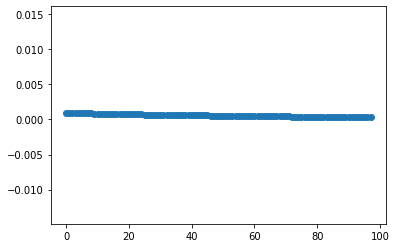

In [26]:
import matplotlib.pyplot as plt
plt.scatter(range(len(square)), square)
plt.axis(option='auto')

plt.show()

In [ ]:
from sklearn import preprocessing


In [ ]:
a_scaled = preprocessing.scale(a)
a_scaled = a_scaled.reshape(len(a_scaled), 1 )
print(a_scaled.shape); print(a_scaled);

In [ ]:
range(.1, 1, .1)